In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
import pandas as pd

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import pickle
from sklearn.datasets import make_sparse_spd_matrix
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray

# Create Raw data

In [ ]:
import requests
import yfinance as yf
import pickle
ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
groups_according_to_ticker = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)
log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]
groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,
        'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

            
with open(f'../data/case_study_etf/raw_etf.pkl', 'wb') as handle:
        pickle.dump(gogn, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Load

In [141]:
with open(f'../data/case_study_etf/gaussian_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
    gaussian_port = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_100.pkl', 'rb') as handle:
    t_port = pickle.load(handle)


with open(f'../data/case_study_etf/t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

# with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_ind_60_diff_kappa.pkl', 'rb') as handle:
#     t_port_diff_kappa = pickle.load(handle)

# with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_ind_60_diff_kappa2.pkl', 'rb') as handle:
#     t_port_diff_kappa2 = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_kappa_0.9_nr_quad_10_etf2.pkl', 'rb') as handle:
    gt_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)




with open(f'../data/case_study_etf/covariance_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
    cov_port = pickle.load(handle)

with open(f'../data/case_study_etf/LedoitWolf_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
    LedoitWolf_port = pickle.load(handle)


In [2]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)


In [88]:
len(t_port['ticker_list']) == len(gaussian_port['ticker_list'])

True

### Plot degrees of freedom

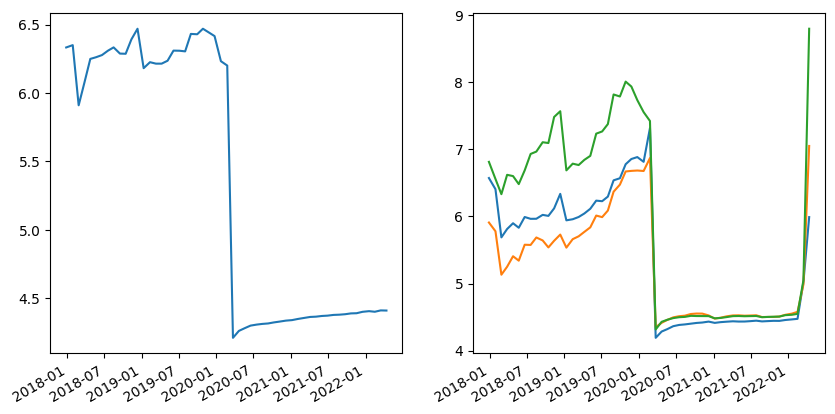

In [228]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(t_port['time_change'],t_port['nus'][0])


ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,0])
ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,1])
ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,6])
fig.autofmt_xdate()


### plot MDD

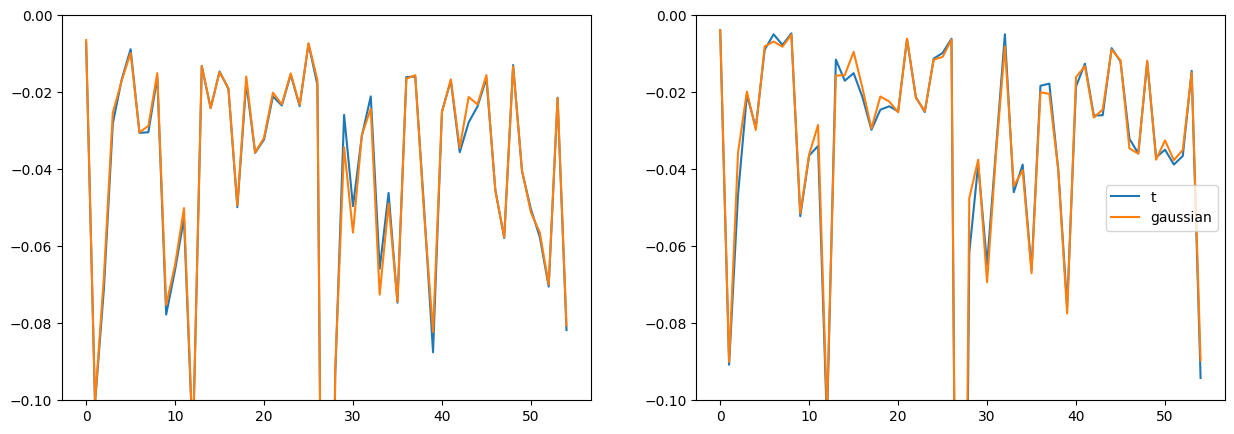

In [10]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
k = 0
ax[0].plot(t_port['mdds_s'][k], label = 't')
ax[0].plot(gaussian_port['mdds_s'][k], label = 'gaussian')
#ax[0].plot(gt_port['mdds_s'][0], label = 'group-t')
ax[0].set_ylim([-0.1,0])

ax[1].plot(t_port['mdds_m'][k], label = 't')
ax[1].plot(gaussian_port['mdds_m'][k], label = 'gaussian')
#ax[1].plot(gt_port['mdds_m'][0], label = 'group-t')
ax[1].set_ylim([-0.1,0])


ax[1].legend()


In [21]:
print(np.mean(t_port['mdds_s'][6]))
print(np.mean(gaussian_port['mdds_s'][5]))
print(np.mean(gt_port['mdds_s'][0]))

-0.041864857319992295
-0.04261037996406856
-0.05158643218699316


KeyError: 1

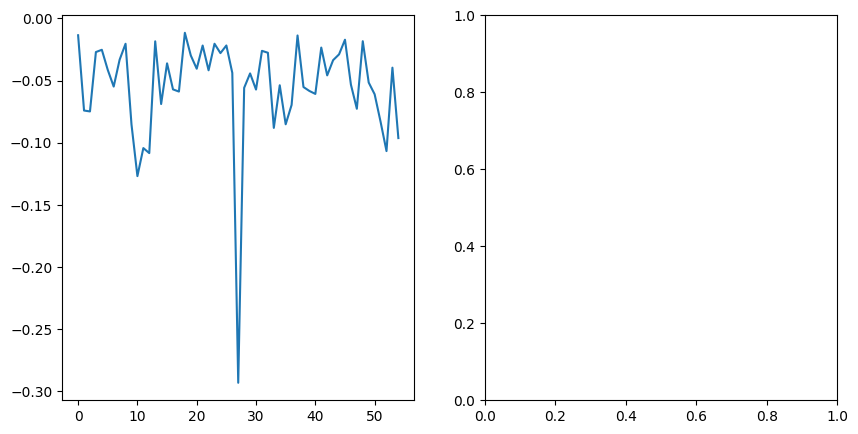

In [199]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0
ax[0].plot(t_port['mdds_s'][0], label = 0)
ax[0].plot(t_port['mdds_s'][1], label = 1)
ax[0].plot(t_port['mdds_s'][2], label = 2)
ax[0].plot(t_port['mdds_s'][3], label = 3)
ax[0].plot(t_port['mdds_s'][4], label = 4)
ax[0].set_ylim([-0.1,0])

ax[1].plot(gaussian_port['mdds_s'][0], label = 0)
ax[1].plot(gaussian_port['mdds_s'][1], label = 1)
ax[1].plot(gaussian_port['mdds_s'][2], label = 2)
ax[1].plot(gaussian_port['mdds_s'][3], label = 3)
ax[1].plot(gaussian_port['mdds_s'][4], label = 4)
ax[1].set_ylim([-0.1,0])

ax[1].legend()

### Plot weights

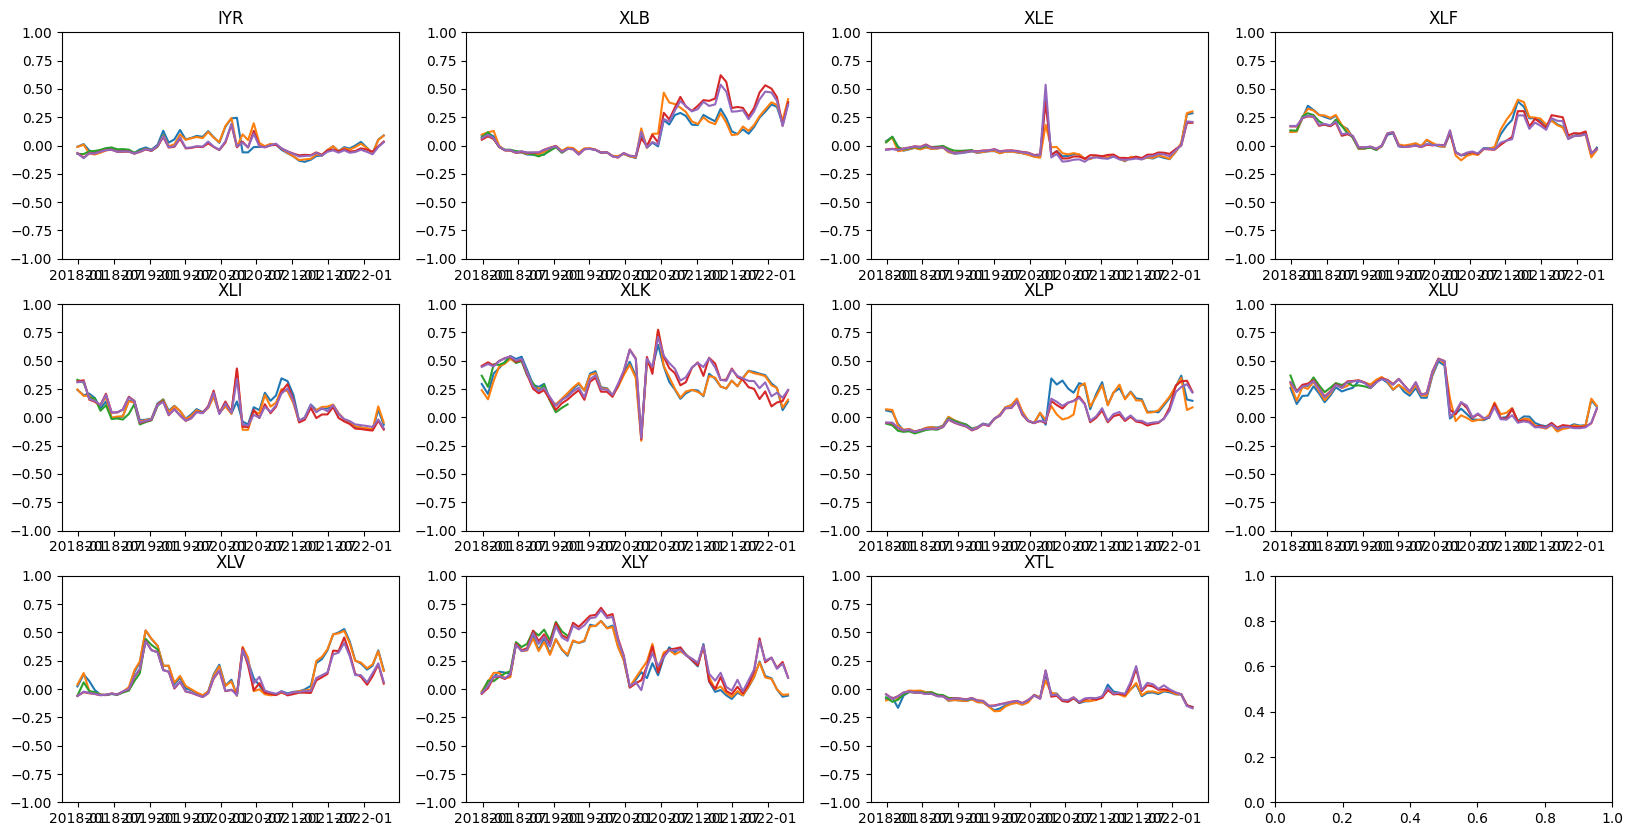

In [82]:
fig, ax = plt.subplots(3,4,figsize = (20,10))
k_n = 3
k_t = 3

w_t_s = np.array(t_port['ws_s'][k_n])
w_n_s = np.array(gaussian_port['ws_s'][k_t])
w_gt_s = np.array(gt_port['ws_s'][0])
w_cov_s = np.array(cov_port['ws_s'][0])
w_lw_s = np.array(LedoitWolf_port['ws_s'][0])

cnt = 0
for i in range(3):
    for j in range(4):
        if cnt == 11:
            break

        ax[i,j].plot(t_port['time_change'], w_t_s[:,cnt], label = 't')
        ax[i,j].plot(gaussian_port['time_change'], w_n_s[:,cnt], label = 'n')
        ax[i,j].plot(gt_port['time_change'][:len(w_gt_s[:,cnt])], w_gt_s[:,cnt], label = 'gt')
        ax[i,j].plot(cov_port['time_change'], w_cov_s[:,cnt], label = 'cov')
        ax[i,j].plot(LedoitWolf_port['time_change'], w_lw_s[:,cnt], label = 'lw')
        ax[i,j].set_title(t_port['X'].columns[cnt])
        ax[i,j].set_ylim((-1,1))

        cnt +=1




### plot cumulative return

In [3]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

[*********************100%***********************]  1 of 1 completed


In [4]:
import yfinance as yf

ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
start_date= "2016-01-01"
end_date="2023-02-01"

data_etf = yf.download(ticker_list, start_date , end_date)
data_etf_u = data_etf['Adj Close'].sum(axis=1)/data_etf.shape[1]

log_returns_etf = np.log(1+data_etf['Adj Close'].pct_change()).dropna()
log_returns_etf_scaled = 100*log_returns_etf.copy()#scaler.fit_transform(log_returns)
price_etf = data_etf['Adj Close'].iloc[1:]
price_etf_u = price_etf.sum(axis=1)/price_etf.shape[1]

[*********************100%***********************]  11 of 11 completed


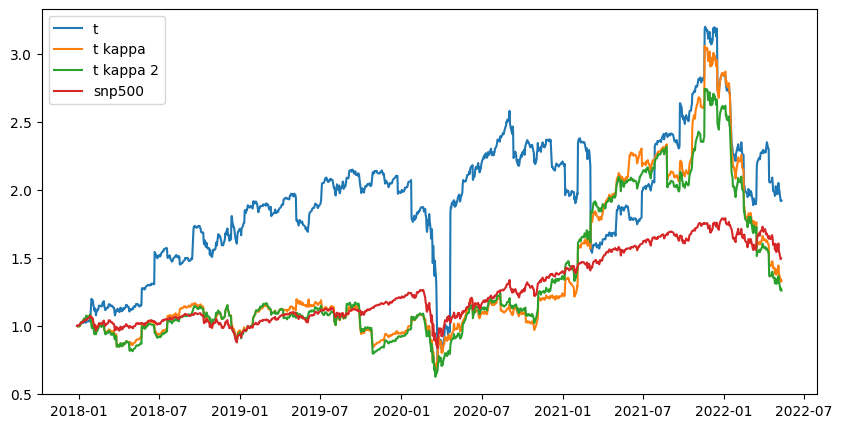

In [346]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
k = 2
t_price_1 = np.cumprod(1+pd.DataFrame(np.concatenate(t_port['port_price_s'][0])).pct_change().dropna())
t_price_2 = np.cumprod(1+pd.DataFrame(np.concatenate(t_port_diff_kappa['port_price_s'][k])).pct_change().dropna())
t_price_3 = np.cumprod(1+pd.DataFrame(np.concatenate(t_port_diff_kappa2['port_price_s'][k])).pct_change().dropna())
ax.plot(np.concatenate(t_port['time_forecast'][k])[1:], t_price_1, label = 't')
ax.plot(np.concatenate(t_port_diff_kappa['time_forecast'][k])[1:], t_price_2, label = 't kappa')
ax.plot(np.concatenate(t_port_diff_kappa2['time_forecast'][k])[1:], t_price_3, label = 't kappa 2')
ax.plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')
ax.legend()

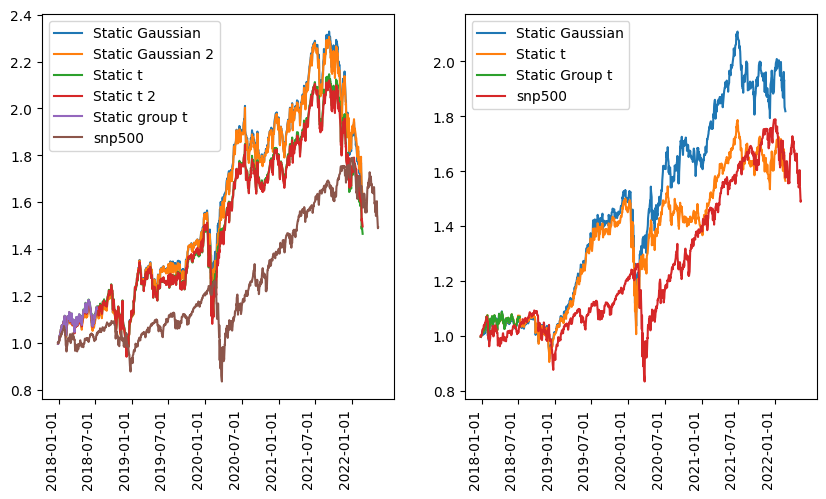

In [6]:
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))

fig, ax = plt.subplots(1,2,figsize = (10,5))
k_n = 2
k_t = 2
# t_price_s = cum_prod_port(t_port['port_price_s'][k_t])
#n_price_s = cum_prod_port(gaussian_port['port_price_s'][k_n]) 
#gt_price_s = cum_prod_port(gt_port['port_price_s'][0]) 
#cov_price_s = cum_prod_port(cov_port['port_price_s'][0]) 
#lw_price_s = cum_prod_port(LedoitWolf_port['port_price_s'][0]) 
s_n_price_s = cum_prod_port(static_gaussian_port['port_price_s'][k_n]) 
s_n_price_s2 = cum_prod_port(static_gaussian_port['port_price_s'][0]) 
s_t_price_s = cum_prod_port(static_t_port['port_price_s'][k_t]) 
s_t_price_s2 = cum_prod_port(static_t_port['port_price_s'][0]) 
s_gt_price_s = cum_prod_port(static_gt_port['port_price_s'][0]) 
#s_gt_port = cum_prod_port(static_gt_port['port_price_s'][1]) 
#ax[0].plot(np.concatenate(t_port['time_forecast'][k_t])[:len(t_price_s)], t_price_s, label = 't')
#ax[0].plot(np.concatenate(gaussian_port['time_forecast'][k_n])[:len(n_price_s)], n_price_s, label = 'gaussian')
#ax[0].plot(np.concatenate(gt_port['time_forecast'][0])[:len(gt_price_s)], gt_price_s, label = 'group t')
#ax[0].plot(np.concatenate(cov_port['time_forecast'][0])[:len(cov_price_s)], cov_price_s, label = 'cov')
#ax[0].plot(np.concatenate(cov_port['time_forecast'][0])[:len(lw_price_s)], lw_price_s, label = 'LedoitWolf')
ax[0].plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price_s)], s_n_price_s, label = 'Static Gaussian')
ax[0].plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price_s)], s_n_price_s2, label = 'Static Gaussian 2')
ax[0].plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price_s)], s_t_price_s, label = 'Static t')
ax[0].plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price_s)], s_t_price_s2, label = 'Static t 2')
ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price_s)], s_gt_price_s, label = 'Static group t')
#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')
# ax[0].plot(np.cumprod(1+data_etf_u.pct_change()[500:1600]), label = 'uniform')
ax[0].legend()

#t_price_m = cum_prod_port(t_port['port_price_m'][k_t])
#n_price_m = cum_prod_port(gaussian_port['port_price_m'][k_n]) 
#gt_price_m = cum_prod_port(gt_port['port_price_m'][0]) 
#cov_price_m = cum_prod_port(cov_port['port_price_m'][0]) 
#lw_price_m = cum_prod_port(LedoitWolf_port['port_price_m'][0])
s_n_price_m = cum_prod_port(static_gaussian_port['port_price_m'][k_n]) 
s_t_price_m = cum_prod_port(static_t_port['port_price_m'][k_t])  
s_gt_price_m = cum_prod_port(static_gt_port['port_price_m'][0]) 
#ax[1].plot(np.concatenate(t_port['time_forecast'][k_t])[:len(t_price_m)], t_price_m, label = 't')
#ax[1].plot(np.concatenate(gaussian_port['time_forecast'][k_n])[:len(n_price_m)], n_price_m, label = 'gaussian')
#ax[1].plot(np.concatenate(gt_port['time_forecast'][0])[:len(gt_price_m)], gt_price_m, label = 'group t')
#ax[1].plot(np.concatenate(cov_port['time_forecast'][0])[:len(cov_price_m)], cov_price_m, label = 'cov')
#ax[1].plot(np.concatenate(cov_port['time_forecast'][0])[:len(lw_price_m)], lw_price_m, label = 'LedoitWolf')
ax[1].plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price_m)], s_n_price_m, label = 'Static Gaussian')
ax[1].plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price_m)], s_t_price_m, label = 'Static t')
ax[1].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price_m)], s_gt_price_m, label = 'Static Group t')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')
ax[1].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')
# ax[1].plot(np.cumprod(1+data_etf_u.pct_change()[500:1600]), label = 'uniform')


ax[1].legend()



Compare static

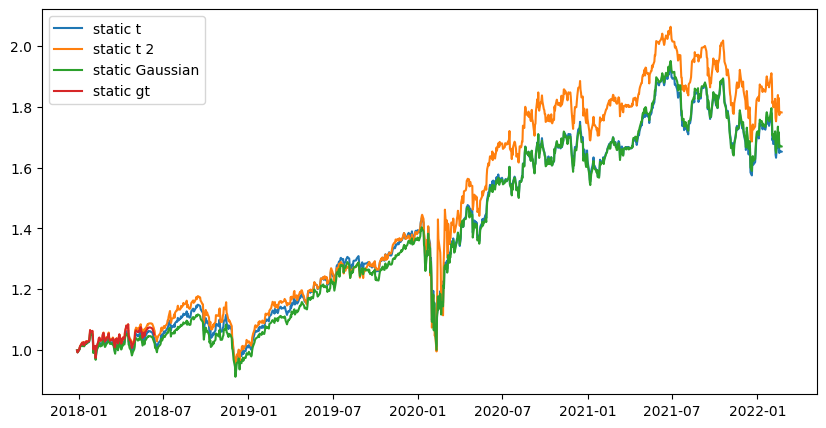

In [172]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

k = 7
s_t_price = cum_prod_port(static_t_port['port_price_s'][k]) 
s_t_price2 = cum_prod_port(static_t_port['port_price_s'][0]) 
s_n_price = cum_prod_port(static_gaussian_port['port_price_s'][9]) 
s_gt_price = cum_prod_port(static_gt_port['port_price_s'][0]) 


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price, label = 'static t')
ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price2, label = 'static t 2')
ax.plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price)], s_n_price, label = 'static Gaussian')
ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

Compare Dynamic

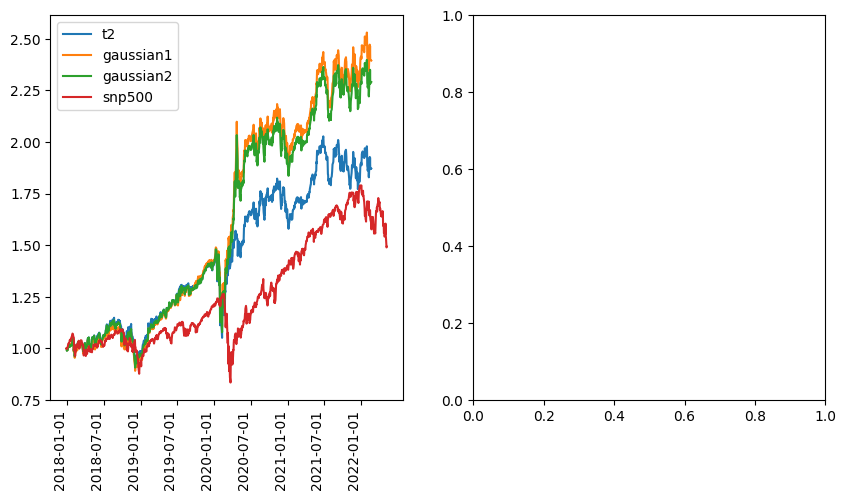

In [181]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_50.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.3_disjoint_50.pkl', 'rb') as handle:
    t_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.4_disjoint_50.pkl', 'rb') as handle:
    t_port3 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.5_disjoint_50.pkl', 'rb') as handle:
    t_port4 = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.1_disjoint_50.pkl', 'rb') as handle:
    gaussian_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.3_disjoint_50.pkl', 'rb') as handle:
    gaussian_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.4_disjoint_50.pkl', 'rb') as handle:
    gaussian_port3 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.5_disjoint_50.pkl', 'rb') as handle:
    gaussian_port4 = pickle.load(handle)

k = 3
s_t_price1 = cum_prod_port(t_port1['port_price_s'][k]) 
s_t_price2 = cum_prod_port(t_port2['port_price_s'][k]) 
s_t_price3 = cum_prod_port(t_port3['port_price_s'][k]) 
s_t_price4 = cum_prod_port(t_port4['port_price_s'][k]) 

s_n_price1 = cum_prod_port(gaussian_port1['port_price_s'][k]) 
s_n_price2 = cum_prod_port(gaussian_port2['port_price_s'][k]) 
s_n_price3 = cum_prod_port(gaussian_port3['port_price_s'][k]) 
s_n_price4 = cum_prod_port(gaussian_port4['port_price_s'][k]) 

fig, ax = plt.subplots(1,2,figsize = (10,5))
#ax[0].plot(np.concatenate(t_port1['time_forecast'][0])[:len(s_t_price1)], s_t_price1, label = 't1')
ax[0].plot(np.concatenate(t_port2['time_forecast'][0])[:len(s_t_price2)], s_t_price2, label = 't2')
#ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax[0].plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax[0].plot(np.concatenate(gaussian_port2['time_forecast'][0])[:len(s_n_price2)], s_n_price2, label = 'gaussian2')
#ax[0].plot(np.concatenate(gaussian_port3['time_forecast'][0])[:len(s_n_price3)], s_n_price3, label = 'gaussian3')
#ax[0].plot(np.concatenate(gaussian_port4['time_forecast'][0])[:len(s_n_price4)], s_n_price4, label = 'gaussian4')

#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax[0].legend()

Compare alpha level

In [155]:
def plot_per_alpha(port):
    fig, ax = plt.subplots(1,1,figsize = (10,5))

    for cnt, alpha in enumerate(port['alphas']):
        if len(port['port_price_s'][cnt])<=0:
            continue
        s_price = cum_prod_port(port['port_price_s'][cnt]) 
        ax.plot(np.concatenate(port['time_forecast'][0])[:len(s_price)], s_price, label = f't {cnt}')


    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    #ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


    ax.legend()

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


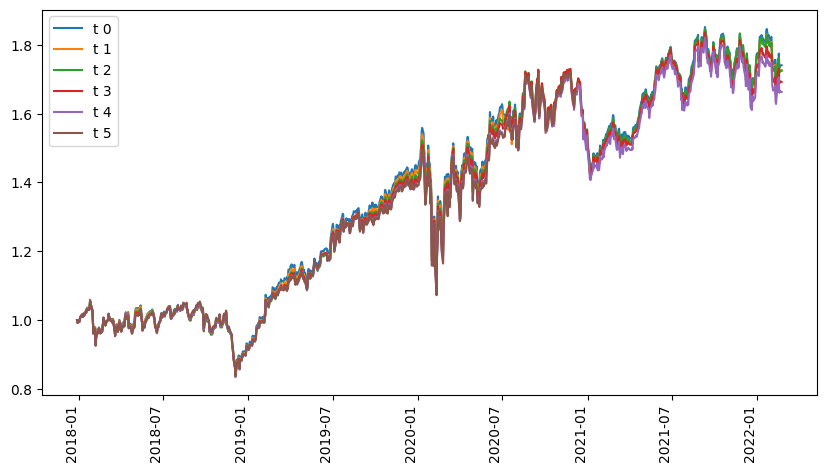

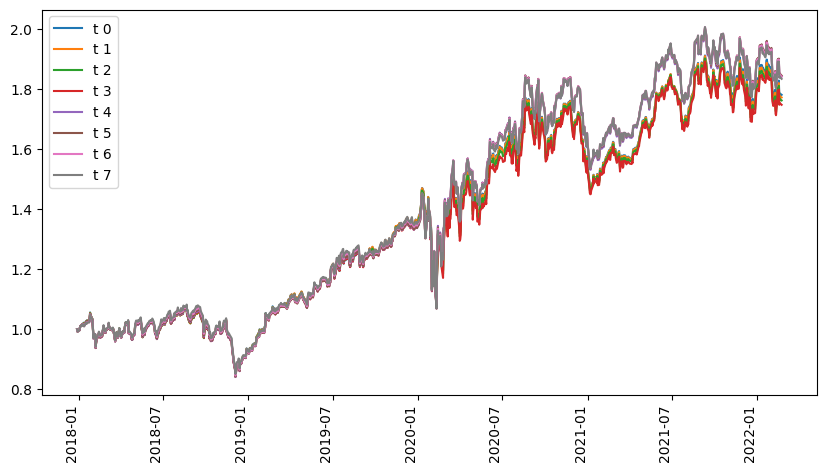

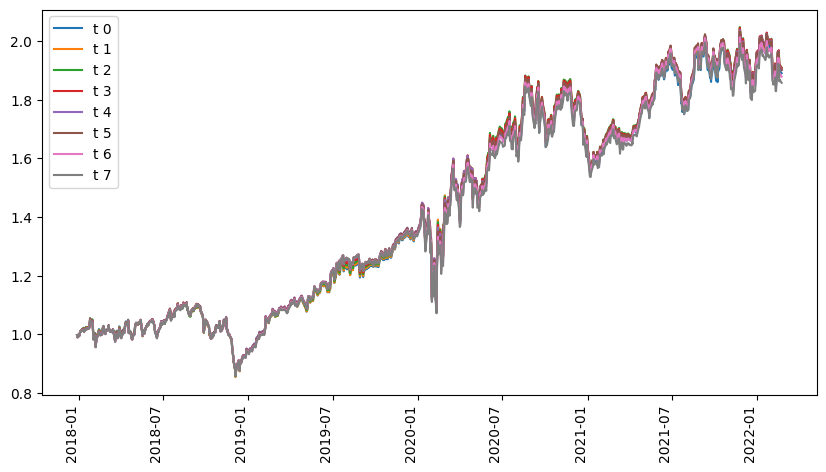

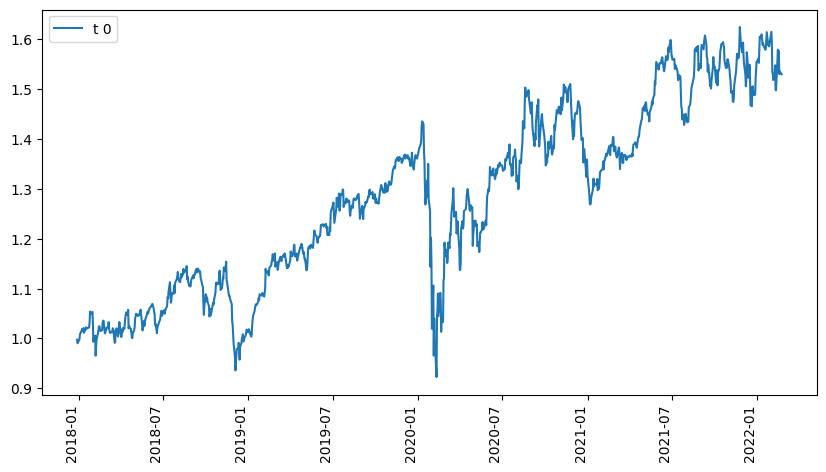

In [159]:


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{1}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

In [195]:
port1['time_change']

DatetimeIndex(['2017-12-28', '2018-01-29', '2018-02-27', '2018-03-27',
               '2018-04-25', '2018-05-23', '2018-06-21', '2018-07-20',
               '2018-08-17', '2018-09-17', '2018-10-15', '2018-11-12',
               '2018-12-12', '2019-01-11', '2019-02-11', '2019-03-12',
               '2019-04-09', '2019-05-08', '2019-06-06', '2019-07-05',
               '2019-08-02', '2019-08-30', '2019-09-30', '2019-10-28',
               '2019-11-25', '2019-12-24', '2020-01-24', '2020-02-24',
               '2020-03-23', '2020-04-21', '2020-05-19', '2020-06-17',
               '2020-07-16', '2020-08-13', '2020-09-11', '2020-10-09',
               '2020-11-06', '2020-12-07', '2021-01-06', '2021-02-04',
               '2021-03-05', '2021-04-05', '2021-05-03', '2021-06-01',
               '2021-06-29', '2021-07-28', '2021-08-25', '2021-09-23',
               '2021-10-21', '2021-11-18', '2021-12-17', '2022-01-18',
               '2022-02-15', '2022-03-16', '2022-04-13'],
              dtype

In [202]:
port1['port_price_s'][6][14]

array([74.76940582, 75.49058872, 76.05142739, 75.6931525 , 77.14869674,
       76.86626957, 77.08093011, 77.12603068, 77.45493993, 77.31863986,
       77.0299854 , 77.67904308, 77.99503555, 82.8691108 , 82.02800626,
       82.19914352, 81.76416883, 81.14588251, 81.06082318, 82.23886418])

In [201]:
port1['port_price_s'][4][14]

array([73.49147119, 75.07099925, 74.54589663, 74.81994515, 75.60548604,
       76.08043821, 76.04699992, 75.77616564, 75.96779823, 76.04338062,
       75.83077385, 75.31221246, 74.58495892, 73.36827286, 73.14908608,
       71.88815176, 70.81939125, 69.72278344, 70.06851236, 70.90246282])

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


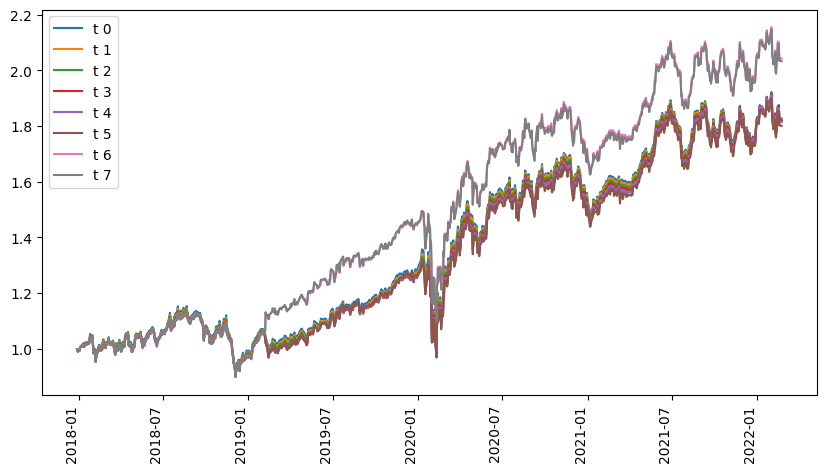

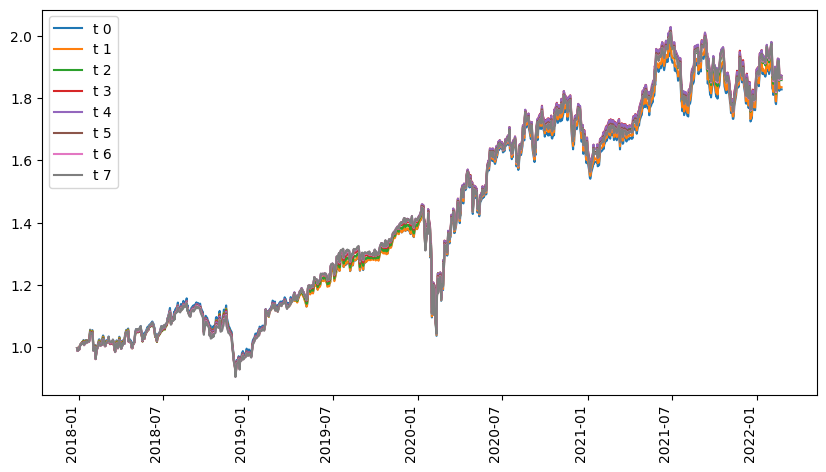

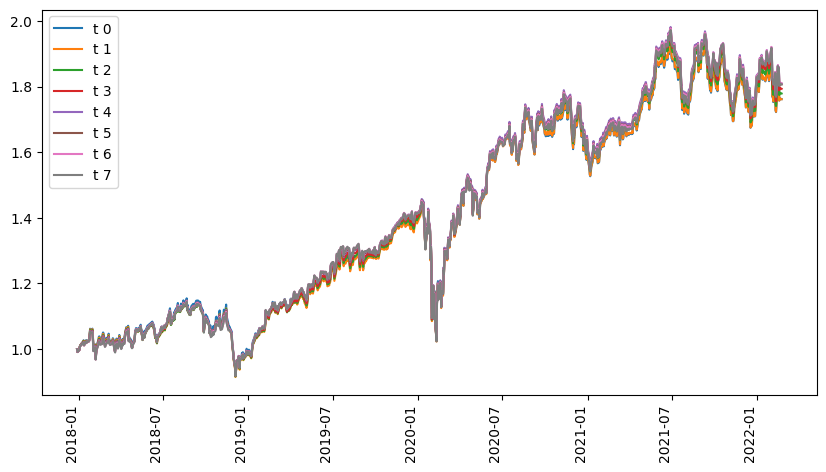

In [206]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_50.pkl', 'rb') as handle:
    port1 = pickle.load(handle)
plot_per_alpha(port1)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_50.pkl', 'rb') as handle:
    port2 = pickle.load(handle)
plot_per_alpha(port2)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_50.pkl', 'rb') as handle:
    port3 = pickle.load(handle)
plot_per_alpha(port3)


Compare different number of observations per graph

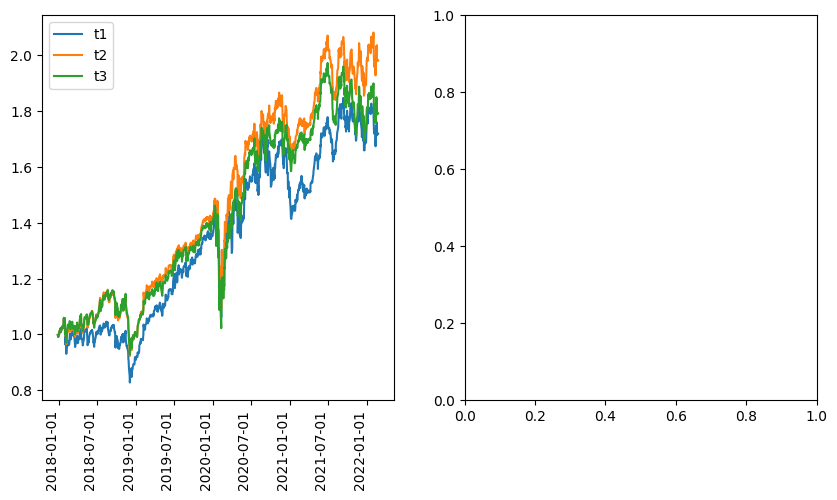

In [217]:
k = 0.2

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_20.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_50.pkl', 'rb') as handle:
    t_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_100.pkl', 'rb') as handle:
    t_port3 = pickle.load(handle)
#with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_250.pkl', 'rb') as handle:
#    t_port4 = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_20.pkl', 'rb') as handle:
    gaussian_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_50.pkl', 'rb') as handle:
    gaussian_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_100.pkl', 'rb') as handle:
    gaussian_port3 = pickle.load(handle)
#with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_250.pkl', 'rb') as handle:
#    gaussian_port4 = pickle.load(handle)



a = 0
s_t_price1 = cum_prod_port(t_port1['port_price_s'][a]) 
s_t_price2 = cum_prod_port(t_port2['port_price_s'][a]) 
s_t_price3 = cum_prod_port(t_port3['port_price_s'][a]) 
s_t_price4 = cum_prod_port(t_port4['port_price_s'][a]) 

s_n_price1 = cum_prod_port(gaussian_port1['port_price_s'][a]) 
s_n_price2 = cum_prod_port(gaussian_port2['port_price_s'][a]) 
s_n_price3 = cum_prod_port(gaussian_port3['port_price_s'][a]) 
s_n_price4 = cum_prod_port(gaussian_port4['port_price_s'][a]) 

fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(np.concatenate(t_port1['time_forecast'][0])[:len(s_t_price1)], s_t_price1, label = 't1')
ax[0].plot(np.concatenate(t_port2['time_forecast'][0])[:len(s_t_price2)], s_t_price2, label = 't2')
ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax[0].plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax[0].plot(np.concatenate(gaussian_port2['time_forecast'][0])[:len(s_n_price2)], s_n_price2, label = 'gaussian2')
ax[0].plot(np.concatenate(gaussian_port3['time_forecast'][0])[:len(s_n_price3)], s_n_price3, label = 'gaussian3')
#ax[0].plot(np.concatenate(gaussian_port4['time_forecast'][0])[:len(s_n_price4)], s_n_price4, label = 'gaussian4')

#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
#ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax[0].legend()

Compare best

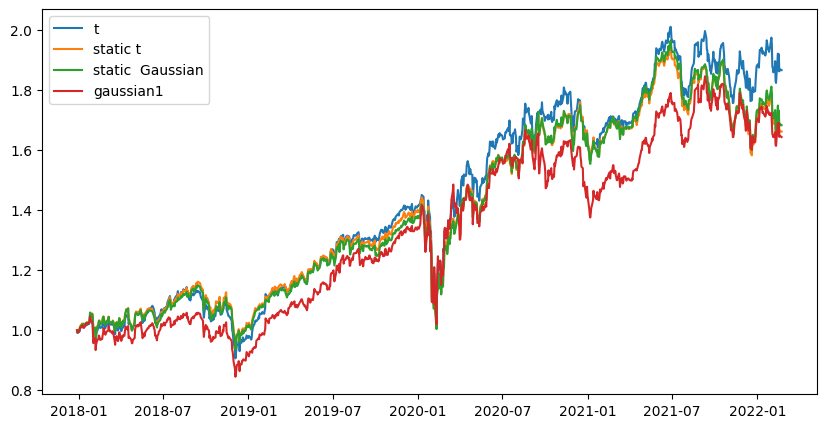

In [173]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_50.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)


t_price = cum_prod_port(t_port1['port_price_s'][7]) 
s_t_price = cum_prod_port(static_t_port['port_price_s'][6]) 
s_n_price = cum_prod_port(static_gaussian_port['port_price_s'][6]) 


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(t_port1['time_forecast'][0])[:len(t_price)], t_price, label = 't')
ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price, label = 'static t')
ax.plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price)], s_n_price, label = 'static  Gaussian')
#ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax.plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax.legend()

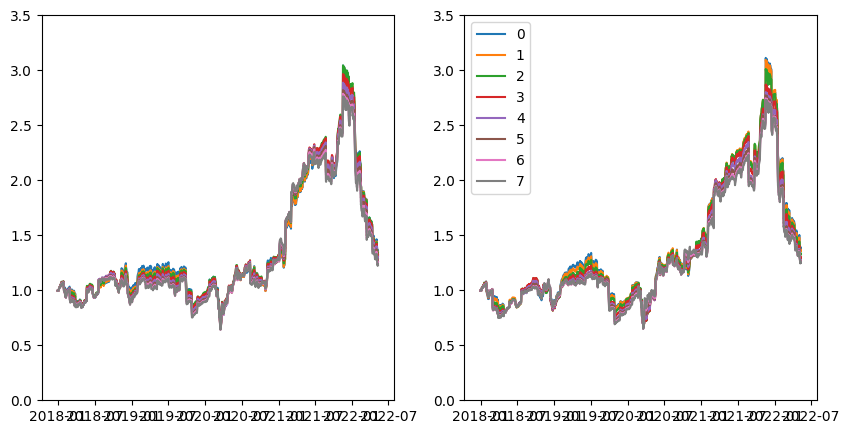

In [307]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0
for i in range(len(t_port['alphas'])):
    ax[0].plot(np.concatenate(t_port['time_forecast'][i])[1:], np.cumprod(1+pd.DataFrame(np.concatenate(t_port['port_price_s'][i])).pct_change().dropna()), label = i)
    ax[0].set_ylim((0,3.5))
for i in range(len(t_port['alphas'])):
    ax[1].plot(np.concatenate(gaussian_port['time_forecast'][i])[1:], np.cumprod(1+pd.DataFrame(np.concatenate(gaussian_port['port_price_s'][i])).pct_change().dropna()), label = i)
    ax[1].set_ylim((0,3.5))

ax[1].legend()

### Plot variance

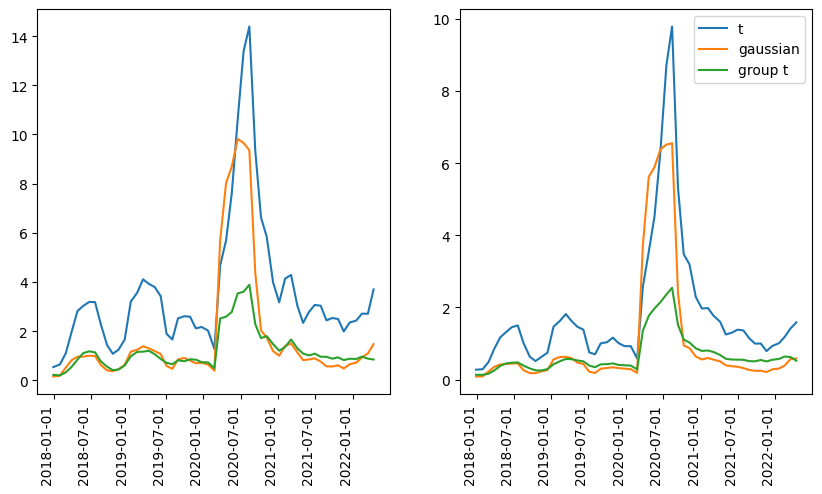

In [207]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0

ax[0].plot(t_port['time_change'], t_port['vars_s'][k], label = 't')
ax[0].plot(t_port['time_change'], gaussian_port['vars_s'][k], label = 'gaussian')
ax[0].plot(t_port['time_change'][:len(gt_port['vars_s'][0])], gt_port['vars_s'][0], label = 'group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

ax[1].plot(t_port['time_change'], t_port['vars_m'][k], label = 't')
ax[1].plot(t_port['time_change'], gaussian_port['vars_m'][k], label = 'gaussian')
ax[1].plot(t_port['time_change'][:len(gt_port['vars_m'][0])], gt_port['vars_m'][0], label = 'group t')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')


ax[1].legend()



KeyError: 1

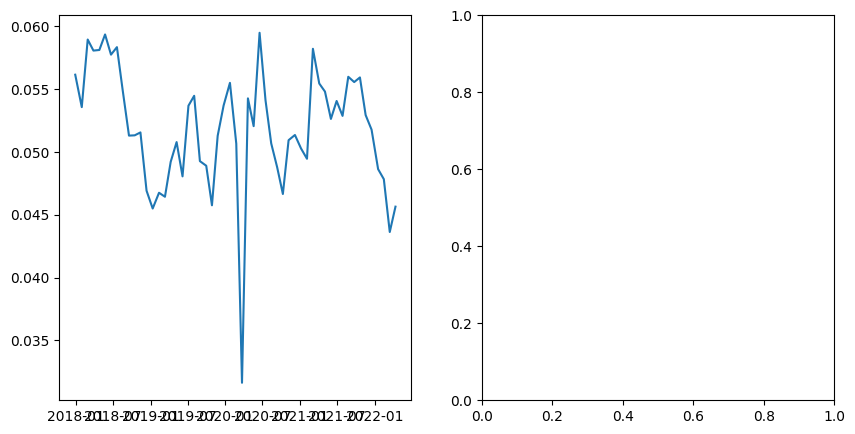

In [123]:
fig, ax = plt.subplots(1,2,figsize = (10,5))


ax[0].plot(t_port['time_change'], t_port['mus_s'][0], label = 0)
ax[0].plot(t_port['time_change'], t_port['mus_s'][1], label = 1)
ax[0].plot(t_port['time_change'], t_port['mus_s'][2], label = 2)
ax[0].plot(t_port['time_change'], t_port['mus_s'][3], label = 3)
ax[0].plot(t_port['time_change'], t_port['mus_s'][4], label = 4)

ax[1].plot(gaussian_port['time_change'], gaussian_port['mus_s'][0], label = 0)
ax[1].plot(gaussian_port['time_change'], gaussian_port['mus_s'][1], label = 1)
ax[1].plot(gaussian_port['time_change'], gaussian_port['mus_s'][2], label = 2)
ax[1].plot(gaussian_port['time_change'], gaussian_port['mus_s'][3], label = 3)
#ax[1].plot(gaussian_port['time_change'], gaussian_port['mus_s'][4], label = 4)

ax[1].legend()

### Plot return

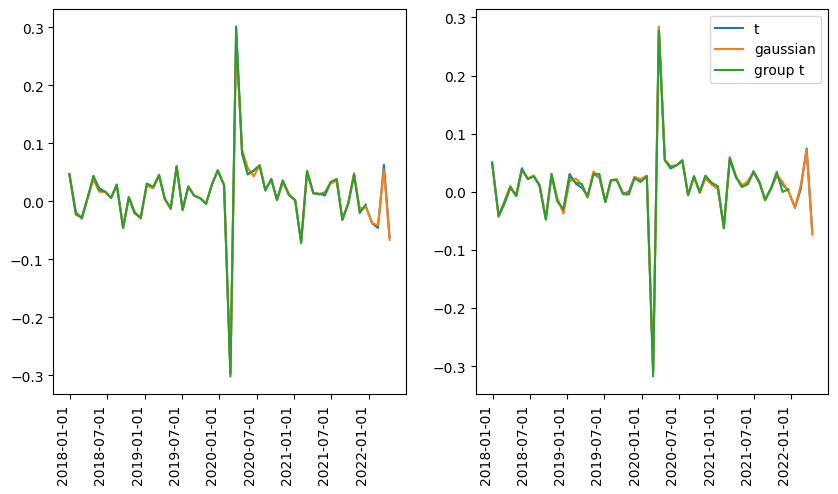

In [124]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0

ax[0].plot(t_port['time_change'], t_port['rs_s'][k], label = 't')
ax[0].plot(t_port['time_change'], gaussian_port['rs_s'][k], label = 'gaussian')
ax[0].plot(t_port['time_change'][:len(gt_port['rs_s'][0])], gt_port['rs_s'][0], label = 'group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

ax[1].plot(t_port['time_change'], t_port['rs_m'][k], label = 't')
ax[1].plot(t_port['time_change'], gaussian_port['rs_m'][k], label = 'gaussian')
ax[1].plot(t_port['time_change'][:len(gt_port['rs_m'][0])], gt_port['rs_m'][0], label = 'group t')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')


ax[1].legend()



### Plot sharpe

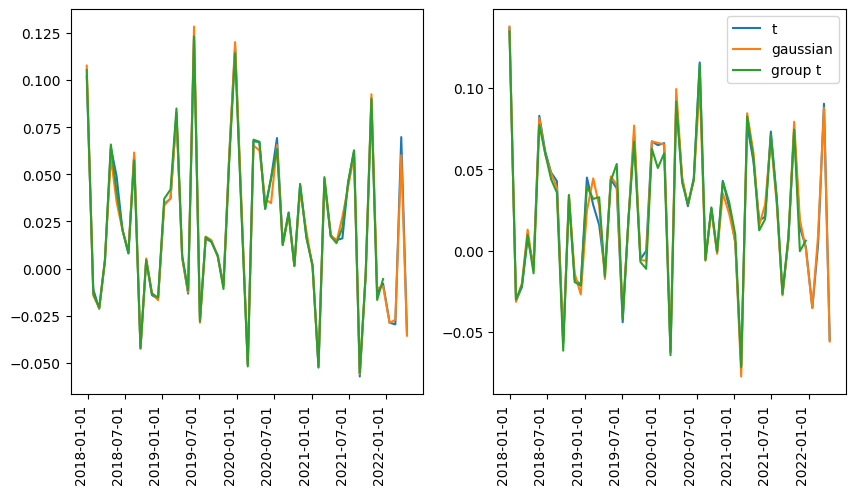

In [125]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0

ax[0].plot(t_port['time_change'], t_port['sharpes_s'][k], label = 't')
ax[0].plot(t_port['time_change'], gaussian_port['sharpes_s'][k], label = 'gaussian')
ax[0].plot(t_port['time_change'][:len(gt_port['sharpes_s'][0])], gt_port['sharpes_s'][0], label = 'group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

ax[1].plot(t_port['time_change'], t_port['sharpes_m'][k], label = 't')
ax[1].plot(t_port['time_change'], gaussian_port['sharpes_m'][k], label = 'gaussian')
ax[1].plot(t_port['time_change'][:len(gt_port['sharpes_m'][0])], gt_port['sharpes_m'][0], label = 'group t')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')


ax[1].legend()



### Plot omegas

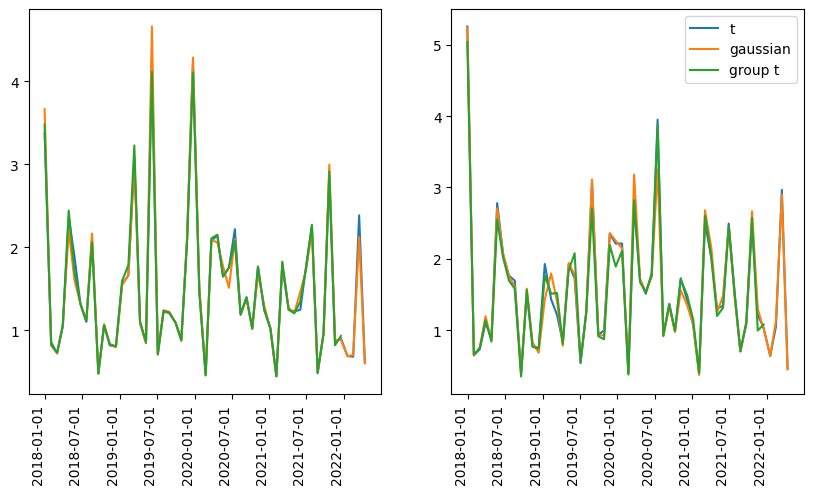

In [126]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0

ax[0].plot(t_port['time_change'], t_port['omegas_s'][k], label = 't')
ax[0].plot(t_port['time_change'], gaussian_port['omegas_s'][k], label = 'gaussian')
ax[0].plot(t_port['time_change'][:len(gt_port['omegas_s'][0])], gt_port['omegas_s'][0], label = 'group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')

ax[1].plot(t_port['time_change'], t_port['omegas_m'][k], label = 't')
ax[1].plot(t_port['time_change'], gaussian_port['omegas_m'][k], label = 'gaussian')
ax[1].plot(t_port['time_change'][:len(gt_port['omegas_m'][0])], gt_port['omegas_m'][0], label = 'group t')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')


ax[1].legend()


In [178]:
import requests
response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" )
ticker_data = pd.read_html(response.content)[0]
ticker_data['group'] = 0
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2


rndstate = np.random.RandomState(6)
index = rndstate.choice(np.array(range(500)),size = 30,replace=False)
ticker_list = np.array(ticker_data['Symbol'].iloc[index]).tolist()
groups_according_to_ticker = np.array(ticker_data['group'].iloc[index])

start_date= "2016-01-01"
end_date="2023-02-01"

import yfinance as yf
data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

# reorder groups according to log_returns scaled as they are in alphabetical order
groups = np.array([j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[*********************100%***********************]  30 of 30 completed


In [180]:
log_returns_scaled.columns

Index(['A', 'AES', 'APD', 'BA', 'BEN', 'BRO', 'CMS', 'CVS', 'EQIX', 'EQR',
       'FDX', 'FIS', 'GRMN', 'GS', 'INTC', 'IT', 'IVZ', 'MCHP', 'META', 'MPC',
       'MSFT', 'MTCH', 'NOC', 'PCAR', 'RHI', 'SIVB', 'SYF', 'SYK', 'TXT',
       'ZBRA'],
      dtype='object')

In [181]:
sorted(zip(ticker_list, groups_according_to_ticker))

[('A', 2),
 ('AES', 0),
 ('APD', 0),
 ('BA', 0),
 ('BEN', 2),
 ('BRO', 2),
 ('CMS', 0),
 ('CVS', 2),
 ('EQIX', 2),
 ('EQR', 2),
 ('FDX', 0),
 ('FIS', 2),
 ('GRMN', 1),
 ('GS', 2),
 ('INTC', 2),
 ('IT', 2),
 ('IVZ', 2),
 ('MCHP', 2),
 ('META', 1),
 ('MPC', 0),
 ('MSFT', 2),
 ('MTCH', 1),
 ('NOC', 0),
 ('PCAR', 0),
 ('RHI', 0),
 ('SIVB', 2),
 ('SYF', 2),
 ('SYK', 2),
 ('TXT', 0),
 ('ZBRA', 2)]

In [179]:
[j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))]  

[2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2]

In [160]:
start_date= "2016-01-01"
end_date="2023-02-01"

import yfinance as yf
data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

[*********************100%***********************]  30 of 30 completed


In [163]:
ticker_list

['PKG',
 'BWA',
 'PNW',
 'DPZ',
 'CVX',
 'RJF',
 'POOL',
 'ED',
 'BIIB',
 'TSCO',
 'AAP',
 'FRT',
 'ROST',
 'CPT',
 'PCG',
 'PHM',
 'WYNN',
 'AEP',
 'MU',
 'SPGI',
 'WY',
 'WHR',
 'LHX',
 'OKE',
 'BMY',
 'UNP',
 'XYL',
 'GRMN',
 'CRL',
 'NWL']

In [162]:
log_returns_scaled.columns

Index(['AAP', 'AEP', 'BIIB', 'BMY', 'BWA', 'CPT', 'CRL', 'CVX', 'DPZ', 'ED',
       'FRT', 'GRMN', 'LHX', 'MU', 'NWL', 'OKE', 'PCG', 'PHM', 'PKG', 'PNW',
       'POOL', 'RJF', 'ROST', 'SPGI', 'TSCO', 'UNP', 'WHR', 'WY', 'WYNN',
       'XYL'],
      dtype='object')

In [165]:
log_returns_scaled.columns

Index(['AAP', 'AEP', 'BIIB', 'BMY', 'BWA', 'CPT', 'CRL', 'CVX', 'DPZ', 'ED',
       'FRT', 'GRMN', 'LHX', 'MU', 'NWL', 'OKE', 'PCG', 'PHM', 'PKG', 'PNW',
       'POOL', 'RJF', 'ROST', 'SPGI', 'TSCO', 'UNP', 'WHR', 'WY', 'WYNN',
       'XYL'],
      dtype='object')

In [167]:
sorted(zip(ticker_list, groups))

[('AAP', 1),
 ('AEP', 0),
 ('BIIB', 2),
 ('BMY', 2),
 ('BWA', 1),
 ('CPT', 2),
 ('CRL', 2),
 ('CVX', 0),
 ('DPZ', 1),
 ('ED', 0),
 ('FRT', 2),
 ('GRMN', 1),
 ('LHX', 0),
 ('MU', 2),
 ('NWL', 1),
 ('OKE', 0),
 ('PCG', 0),
 ('PHM', 1),
 ('PKG', 0),
 ('PNW', 0),
 ('POOL', 1),
 ('RJF', 2),
 ('ROST', 1),
 ('SPGI', 2),
 ('TSCO', 1),
 ('UNP', 0),
 ('WHR', 1),
 ('WY', 2),
 ('WYNN', 1),
 ('XYL', 0)]

In [164]:
np.where(log_returns_scaled.columns == ticker_list)

(array([25], dtype=int64),)

### MMD between matrices

In [104]:
t_port['Ss'][0]

[array([[ 0.40694009,  0.11268457,  0.07256155,  0.07668409,  0.10282186,
          0.11503969,  0.13685837,  0.17818374,  0.07152661,  0.12653499,
          0.15538891],
        [ 0.11268457,  0.46395931,  0.24139761,  0.29887974,  0.2767459 ,
          0.22969721,  0.09683661,  0.01449951,  0.13444185,  0.21875873,
          0.28061071],
        [ 0.07256155,  0.24139761,  0.66990648,  0.21940584,  0.16885511,
          0.09204396,  0.03918344, -0.00427547,  0.0546681 ,  0.11072932,
          0.17285539],
        [ 0.07668409,  0.29887974,  0.21940584,  0.62441271,  0.30743875,
          0.24666341,  0.07885716, -0.07674053,  0.1670924 ,  0.25059681,
          0.31052125],
        [ 0.10282186,  0.2767459 ,  0.16885511,  0.30743875,  0.3510012 ,
          0.23291782,  0.10182053,  0.02057851,  0.14620386,  0.220679  ,
          0.2546925 ],
        [ 0.11503969,  0.22969721,  0.09204396,  0.24666341,  0.23291782,
          0.4290805 ,  0.13143337,  0.0354417 ,  0.19789067,  0.2646867

In [16]:
gaussian_port['Ss'][0][25]

array([[0.58858782, 0.24688863, 0.18511434, 0.23768209, 0.275686  ,
        0.34048645, 0.32991663, 0.31592916, 0.30484103, 0.30419523,
        0.3034444 ],
       [0.24688863, 0.93248292, 0.71641268, 0.69651224, 0.77461315,
        0.73093537, 0.36336424, 0.07279198, 0.45349959, 0.60361756,
        0.69193236],
       [0.18511434, 0.71641268, 1.53845454, 0.83552787, 0.81694025,
        0.80647774, 0.3166719 , 0.01767632, 0.49555379, 0.66588279,
        0.84322443],
       [0.23768209, 0.69651224, 0.83552787, 1.0920955 , 0.8081374 ,
        0.83106202, 0.38155678, 0.05753096, 0.52783424, 0.6892334 ,
        0.80713234],
       [0.275686  , 0.77461315, 0.81694025, 0.8081374 , 0.98310879,
        0.8310421 , 0.38741279, 0.0768172 , 0.50493322, 0.68991031,
        0.7949517 ],
       [0.34048645, 0.73093537, 0.80647774, 0.83106202, 0.8310421 ,
        1.31901089, 0.41997633, 0.11337453, 0.65518485, 0.88377904,
        0.94986228],
       [0.32991663, 0.36336424, 0.3166719 , 0.38155678, 0.

In [30]:
import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(t_port['Ss'][0][i]) for i in range(20)], G2 = [nx.from_numpy_array(gaussian_port['Ss'][0][i]) for i in range(20)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 6, c = 0.00008, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.383}


<AxesSubplot:>

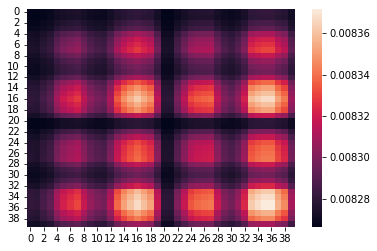

In [31]:
import seaborn as sns
sns.heatmap(MMD_out.K)

In [51]:
len(gt_port['Ss'][0])

21

In [57]:
gt_port['thetas'][0][-1]

array([[[ 4.08608605, -0.13050656,  0.16215641, ..., -0.0452828 ,
         -0.89832004, -0.13209369],
        [-0.13050656,  4.4375643 , -0.61803935, ...,  0.20490182,
         -0.2447168 , -0.15044082],
        [ 0.16215641, -0.61803935,  1.59469283, ..., -0.22213131,
         -0.27891629, -0.08004994],
        ...,
        [-0.0452828 ,  0.20490182, -0.22213131, ...,  4.68138873,
         -0.29033703,  0.04825175],
        [-0.89832004, -0.2447168 , -0.27891629, ..., -0.29033703,
          6.53040941, -0.83346136],
        [-0.13209369, -0.15044082, -0.08004994, ...,  0.04825175,
         -0.83346136,  2.41302645]],

       [[ 4.08561824, -0.1315588 ,  0.16037965, ..., -0.04555137,
         -0.89875567, -0.13300222],
        [-0.1315588 ,  4.43724261, -0.62052697, ...,  0.20382897,
         -0.24817573, -0.15265228],
        [ 0.16037965, -0.62052697,  1.59205182, ..., -0.22349923,
         -0.28106878, -0.0819152 ],
        ...,
        [-0.04555137,  0.20382897, -0.22349923, ...,  

In [71]:
import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(t_port['thetas'][0][i][-1]) for i in range(10,20)], G2 = [nx.from_numpy_array(gaussian_port['thetas'][0][i][-1]) for i in range(10,20)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 5, c = 0.005, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.006}


In [75]:
gt_port['Ss'][0][0]

array([[ 0.42465705,  0.10508556,  0.07127481,  0.07225937,  0.0933854 ,
         0.11107053,  0.13074265,  0.17869316,  0.06384055,  0.11636746,
         0.14856416],
       [ 0.10508556,  0.44345818,  0.23723943,  0.28703186,  0.25657384,
         0.21427276,  0.08065005,  0.00468791,  0.123169  ,  0.19549531,
         0.26372837],
       [ 0.07127481,  0.23723943,  0.6615836 ,  0.21255977,  0.16038563,
         0.08775042,  0.02751214, -0.00831321,  0.04989833,  0.09666234,
         0.164366  ],
       [ 0.07225937,  0.28703186,  0.21255977,  0.64123282,  0.29305948,
         0.24208324,  0.0660708 , -0.08765702,  0.17302809,  0.23510618,
         0.29881118],
       [ 0.0933854 ,  0.25657384,  0.16038563,  0.29305948,  0.32141092,
         0.21535788,  0.08586058,  0.01022409,  0.13509998,  0.19606624,
         0.2331417 ],
       [ 0.11107053,  0.21427276,  0.08775042,  0.24208324,  0.21535788,
         0.43134888,  0.12075685,  0.0270984 ,  0.19441904,  0.24728226,
         0.303

In [125]:
def off_zero(X):
    X_TMP = X.copy()

    np.fill_diagonal(X_TMP, 0)
    return X_TMP

import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(off_zero(t_port['Ss'][0][i])) for i in range(30)], G2 = [nx.from_numpy_array(off_zero(gaussian_port['Ss'][0][i])) for i in range(30)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 5, c = 0.00005, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.358}


In [91]:
MMD_out.sample_mmd

{'MMD_u': 1.5366328264106166e-05}